<a href="https://colab.research.google.com/github/yassarmohammed87/SpaceShipTitanic-Kaggle/blob/main/Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle competitions download -c spaceship-titanic


  0% 0.00/299k [00:00<?, ?B/s]
100% 299k/299k [00:00<00:00, 74.5MB/s]


In [ ]:
!mkdir spaceTitanic 
!cp train.csv ./spaceTitanic/
!cp test.csv ./spaceTitanic/
!rm -rf test.csv
!rm -rf train.csv

In [ ]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [2]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import CategoricalImputer
import xgboost as xgb
from catboost import CatBoostClassifier, Pool



In [69]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')
# df['Transported']=df['Transported'].astype(np.int64)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines
...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,True,Gravior Noxnuther
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,False,Kurta Mondalley
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,False,Fayey Connon
8691,9280_01,Europa,False,E/608/S,55 Cancri e,False,Celeon Hontichre


In [74]:
cabin_df=df['Cabin'].str.split('/',expand=True)
df['Cabin_Num']=cabin_df[1].fillna(0).astype('int')

In [75]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Cabin_Num
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,98
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,1499
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,1500
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,608


(0.0, 2000.0)

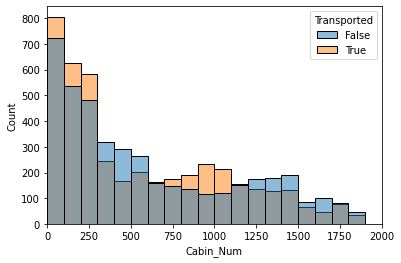

In [ ]:
df.head(100)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0103_01,Earth,False,F/24/S,TRAPPIST-1e,24.0,False,0.0,NaN,0.0,0.0,17.0,Arlen Mclainez,True
96,0103_02,Earth,True,G/18/S,55 Cancri e,9.0,False,0.0,0.0,0.0,0.0,0.0,Shaele Mclainez,True
97,0103_03,Earth,True,G/18/S,TRAPPIST-1e,6.0,False,0.0,0.0,0.0,0.0,0.0,Fanne Mclainez,False
98,0105_01,Earth,NaN,F/21/P,TRAPPIST-1e,27.0,False,0.0,0.0,570.0,2.0,131.0,Carry Cleachrand,False


# Checking Null values

In [ ]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [22]:
def category_comp_plot(field):
  col_series=df[field].value_counts().index
  
  fig, axs = plt.subplots(1, len(col_series), figsize=(12, 5))
  for i,category in enumerate(col_series):
    plt.subplot(1,len(col_series),i+1)
    sns.countplot(data=df.loc[df[field]==category],x='Transported')
    plt.title(category)

plt.subplots_adjust(left=2,right=3)
    


<Figure size 432x288 with 0 Axes>

In [107]:
def numeric_comp_plot(field,binwidth,xlim=None,ylim=None):
  my_df=df.copy()
  my_df[field].fillna(my_df[field].median(),inplace=True)
  my_df[field]=my_df[field].astype('int')
  sns.histplot(data=my_df,x=field,hue='Transported',binwidth=binwidth)
  plt.xlim(xlim)
  plt.ylim(ylim)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


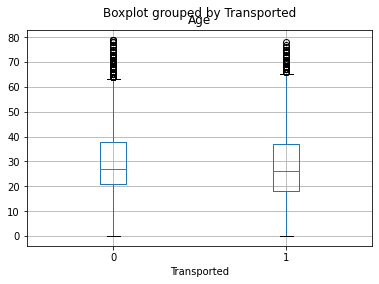

In [ ]:
df.boxplot(column='Age',by='Transported')

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


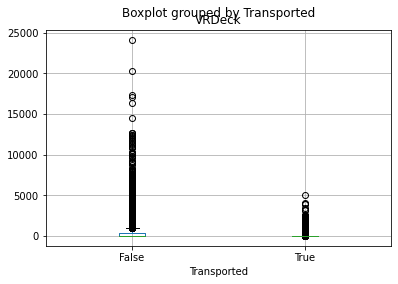

In [97]:
df.boxplot(column='VRDeck',by='Transported')

###**Checking significance of VIP column**

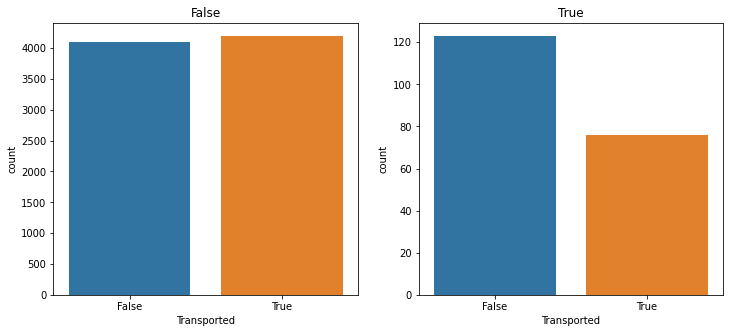

In [ ]:
category_comp_plot('VIP')


Can conclude that being a vip isnt contributing heavily to the target variable

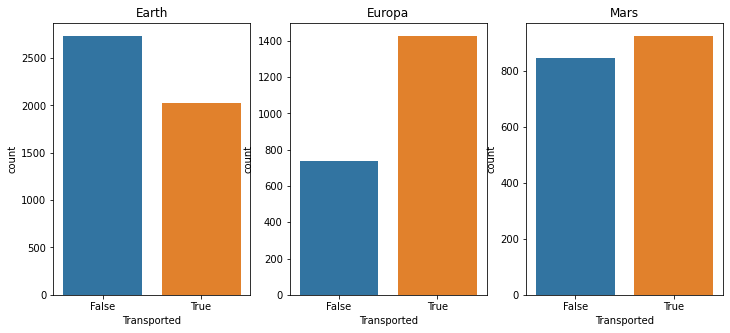

In [ ]:
category_comp_plot('HomePlanet')

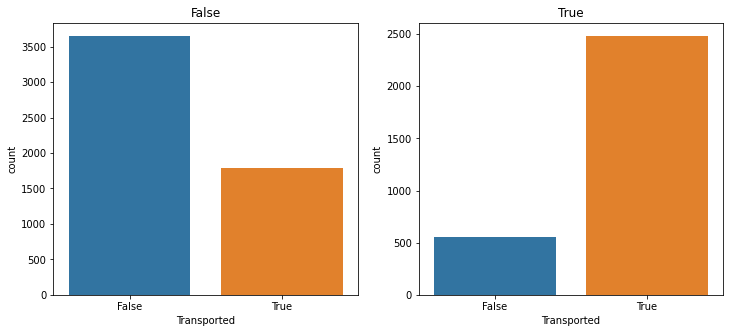

In [ ]:
category_comp_plot('CryoSleep')

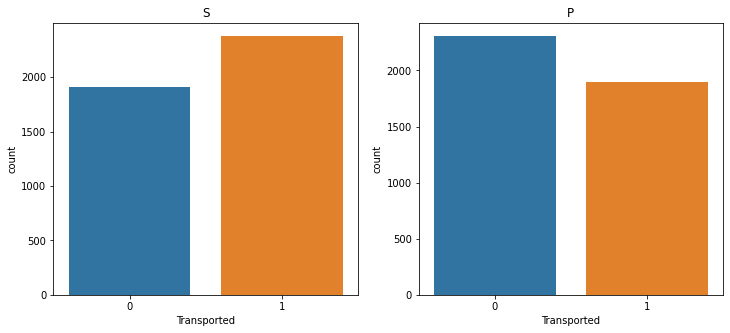

In [ ]:
df['Port']=df['Cabin'].str[-1]
category_comp_plot('Port')

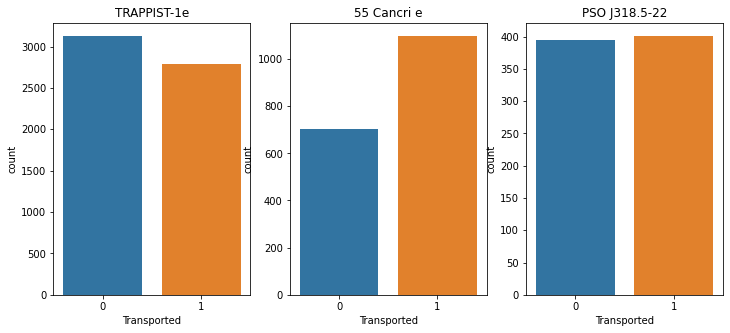

In [ ]:
category_comp_plot('Destination')

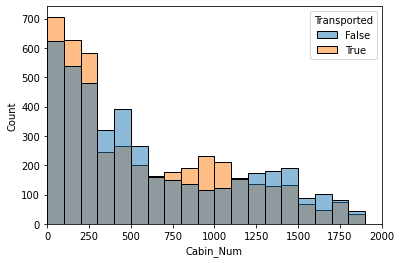

In [108]:
df['Cabin_Num']=df['Cabin'].str.split('/',expand=True)[1]
numeric_comp_plot('Cabin_Num',binwidth=100,xlim=[0,2000])

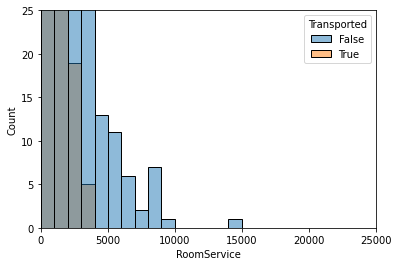

In [109]:

numeric_comp_plot('RoomService',binwidth=1000,xlim=[0,25000],ylim=[0,25])

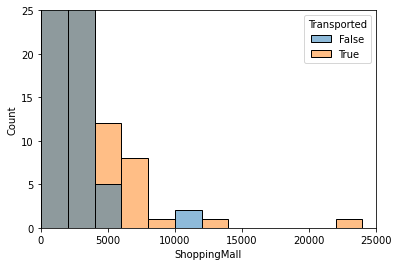

In [111]:
numeric_comp_plot('ShoppingMall',binwidth=2000,xlim=[0,25000],ylim=[0,25])

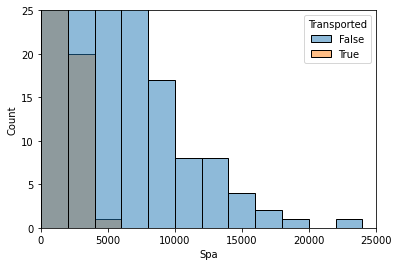

In [112]:
numeric_comp_plot('Spa',binwidth=2000,xlim=[0,25000],ylim=[0,25])

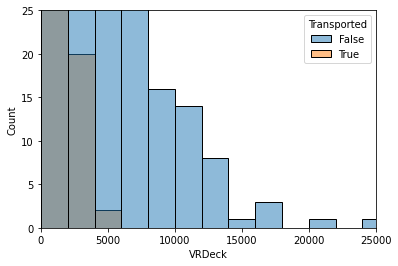

In [113]:
numeric_comp_plot('VRDeck',binwidth=2000,xlim=[0,25000],ylim=[0,25])

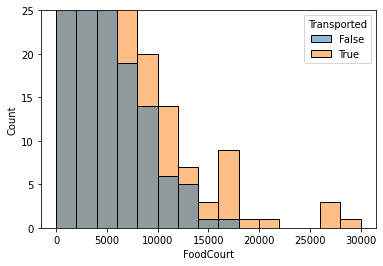

In [114]:
numeric_comp_plot('FoodCourt',binwidth=2000,ylim=[0,25])

In [92]:
df['ShoppingMall'].describe()

count     8485.000000
mean       173.729169
std        604.696458
min          0.000000
25%          0.000000
50%          0.000000
75%         27.000000
max      23492.000000
Name: ShoppingMall, dtype: float64

In [ ]:
df.loc[~df['Cabin'].isna(),'Cabin'].str.split('/').apply(lambda x:x[1]).nunique()

1817

In [ ]:
df['P_Id1'].value_counts()

4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: P_Id1, Length: 6217, dtype: int64

In [ ]:
df.loc[df['P_Id1']==10,'Transported']

13    False
Name: Transported, dtype: bool

# Transformers

In [171]:
class cat_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,categ_cols):
    self.categ_cols=categ_cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    
    
    true_transported=X['Transported'].value_counts().loc[True]
    false_transported=X['Transported'].value_counts().loc[False]
    for i in self.categ_cols:
      true_prob=[]
      false_prob=[]
      tp=X.loc[~X[i].isna()].copy(deep=True)
      
      for j in tp[i].value_counts().index:
        true_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==True)].shape[0]/true_transported)
        false_prob.append(tp.loc[(X[i]==j) & (tp['Transported']==False)].shape[0]/false_transported)

        # try:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.str.count().sum()/false_transported)]}).loc[False][(i,j)])
        # except:
        #   true_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/true_transported)]}).loc[True][(i,j)])
        #   false_prob.append(X[~df[i].isna()].groupby('Transported').agg({i:[(j,lambda x:x.count().sum()/false_transported)]}).loc[False][(i,j)])
      X.loc[(X[i].isna()) & (X['Transported']==True),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==True),i].shape,
                                                                                p=true_prob/sum(true_prob))
      X.loc[(X[i].isna()) & (X['Transported']==False),i]=np.random.choice(X[i].value_counts().index,
                                                                                X.loc[(X[i].isna()) & (X['Transported']==False),i].shape,
                                                                                p=true_prob/sum(true_prob))
    
    return X

class Int_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    imputer=SimpleImputer(strategy="median")
    imputer.fit(X[self.cols])
    X[self.cols]=imputer.transform(X[self.cols])
  
    return X
  


class AttriAdder(BaseEstimator,TransformerMixin):

  def __init__(self):
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X['EscapeSpent']=X['RoomService']+X['Spa']+X['VRDeck']
    X['DeathSpent']=X['FoodCourt']+X['ShoppingMall']
    X['inSurvivorsGroup']=X['P_ID1'].apply(lambda x:1 if x in survivorsIds else 0)
    return X


class OrdEncoding(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    ord=OrdinalEncoder()
    for col in self.cols:
      X[col]=ord.fit_transform(X[[col]])

    return X

class OneHot(BaseEstimator,TransformerMixin):

  def __init__(self,cols):
    self.cols=cols
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    
    for col in self.cols:
      one=OneHotEncoder(sparse=False)
      X[list(one.categories_[0])]=one.fit_transform(X[[col]])
      print(list(one.categories_[0]))

    return X

class TypeChange(BaseEstimator,TransformerMixin):

  def __init__(self,cols_dict):
    self.cols_dict=cols_dict
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for col in self.cols_dict:
      X[col]=X[col].astype(self.cols_dict[col])
    return X

class Dropcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_drop):
    self.to_drop=to_drop
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X.drop(columns=self.to_drop,axis=1)
    return X

class Keepcols(BaseEstimator,TransformerMixin):

  def __init__(self,to_keep):
    self.to_keep=to_keep
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    X=X[self.to_keep]
    return X

class Scaler(BaseEstimator,TransformerMixin):
  def __init__(self,cols=None):
    self.cols=cols
    pass
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    if self.cols==None:
      self.cols=X.columns
    scaler=StandardScaler()
    X[self.cols]=scaler.fit_transform(X[self.cols])
    return X

class ModeImputer(BaseEstimator,TransformerMixin):
  def __init__(self,cols):
    self.cols=cols
    
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.cols:
      cat_imputer=CategoricalImputer()
      X[i]=cat_imputer.fit_transform(X[i])
    return X

class Binner(BaseEstimator,TransformerMixin):
  def __init__(self,cols,cats=4):
    self.cols=cols
    self.cats=cats
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.cols:
      X[i]=pd.qcut(X[i],self.cats,labels=False)
    return X

class Value_Imputer(BaseEstimator,TransformerMixin):
  def __init__(self,col_val):
    self.col_val=col_val
  def fit(self,X,y=None):
    return self
  def transform(self,X,y=None):
    for i in self.col_val:
      X[i]=X[i].fillna(value=self.col_val[i])
    return X


# Functions for test dataset

In [188]:
def split(dataset,label_name):
  dataset=dataset.sample(frac=1,random_state=42)
  labels=dataset[label_name]
  dataset=dataset.drop(columns=[label_name])
  train,test,train_labels,test_labels=train_test_split(dataset,labels,test_size=0.1,random_state=42)
  return {'train':train,'train_labels':train_labels,'test':test,'test_labels':test_labels}

In [189]:
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')
df[['P_ID1','P_ID2']]=df['PassengerId'].str.split('_',expand=True)[[0,1]]
train,train_labels,test,test_labels=split(df,'Transported').values()
survivorsIds=train.loc[df['Transported']==False,'P_ID1'].values
train_labels=train_labels.astype(np.int64)
test_labels=test_labels.astype(np.int64)

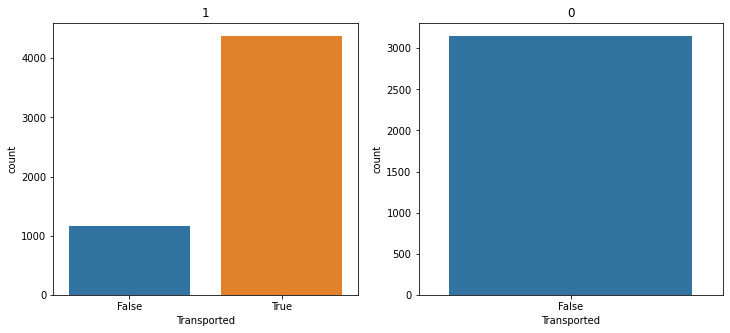

In [168]:
category_comp_plot('inSurvivorsGroup')

In [167]:
df['inSurvivorsGroup'].value_counts()

1    5543
0    3150
Name: inSurvivorsGroup, dtype: int64

# Adding Side from Cabin

In [190]:
train[['deck','num','side']]=train['Cabin'].str.split('/',expand=True)[[0,1,2]]
test[['deck','num','side']]=test['Cabin'].str.split('/',expand=True)[[0,1,2]]
train[['P_ID1','P_ID2']]=train['PassengerId'].str.split('_',expand=True)[[0,1]]
test[['P_ID1','P_ID2']]=test['PassengerId'].str.split('_',expand=True)[[0,1]]

# Imputing HomePlanet

In [191]:
def HomePlanetImpute(df):
  df['deck']=df['Cabin'].str[0]
  deck_to_cab={'A':'Europa','C':'Europa','B':'Europa','T':'Europa','D':'Mars','E':'Earth','G':'Earth','F':'Earth'}
  for i in deck_to_cab:
    df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet']=df.loc[(df['deck']==i) & df['HomePlanet'].isna(),'HomePlanet'].fillna(
        value=deck_to_cab.get(i,'F'))
  return df

In [192]:
train=HomePlanetImpute(train)
test=HomePlanetImpute(test)

In [ ]:
int_imp=Int_Imputer(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
df=int_imp.fit_transform(df)
# val_imp=Value_Imputer({'Name':'Random Random'})
# df=val_imp.fit_transform(df)
attri_adder=AttriAdder()
df=attri_adder.fit_transform(df)
binner=Binner(['Age'],4)
df=binner.fit_transform(df)
modeImp=ModeImputer(['HomePlanet','CryoSleep','side','Destination','VIP'])
df=modeImp.fit_transform(df)
type_change=TypeChange({'Transported':np.int64})
df=type_change.fit_transform(df)
one_hot=OneHot(['HomePlanet','side','Destination','P_ID2'])
df=one_hot.fit_transform(df)
# drp_cls=Dropcols(['Name','Cabin','Destination','HomePlanet','side','PassengerId','RoomService','VRDeck','Spa'])
# df=drp_cls.fit_transform(df)
# bin=Binner(['Age'],4)
# df=bin.fit_transform(df)
# keep_cls=Keepcols(['TotalSpent','Earth','Europa','CryoSleep','Transported'])
# non_cat_df=keep_cls.fit_transform(df)
keep_cls=Keepcols(['RoomService','Spa','VRDeck','HomePlanet','Transported','CryoSleep','side','Destination','P_ID2','VIP','Age'])
cat_df=keep_cls.fit_transform(df)
scaler=Scaler(['RoomService','Spa','VRDeck','Age'])
cat_df=scaler.fit_transform(cat_df)
# xg_df=scaler.fit_transform(xg_df)

KeyError: ignored

In [ ]:
df['Destination'].mode().values[0]

'TRAPPIST-1e'

# Non Cat Pipeline

In [28]:
from sklearn.pipeline import Pipeline


In [ ]:

non_Pipe=Pipeline([('val_imp',Value_Imputer({'Age':train['Age'].mean(),'RoomService':train['RoomService'].median(),
                                            'FoodCourt':train['FoodCourt'].mean(),'ShoppingMall':train['ShoppingMall'].mean()
                                            ,'Spa':train['Spa'].mean(),'VRDeck':train['VRDeck'].mean(),
                                            'HomePlanet':train['HomePlanet'].mode().values[0],
                                            'CryoSleep':train['CryoSleep'].mode().values[0],
                                            'Destination':train['Destination'].mode().values[0],
                                            'VIP':train['VIP'].mode().values[0]})),
                    ('attri_adder',AttriAdder()),
                    ('val_imp2',Value_Imputer({'side':train['side'].mode().values[0]})),
                    ('binner',Binner(['Age'],4)),
                    ('typ_change',TypeChange({'CryoSleep':np.int64,'VIP':np.int64})),
                    ('one_hot',OneHot(['HomePlanet','side','Destination','P_ID2'])),
                    ('keep_cls',Keepcols(['TotalSpent','Earth','Europa','CryoSleep','P','VIP','Age',
                                          'TRAPPIST-1e','55 Cancri e','PSO J318.5-22',
                                          '01','02','03','04','05','06','07','08'])),
                    ('scaler',Scaler(['TotalSpent','CryoSleep','VIP','Age']))
                    ],verbose=False)



In [ ]:
train=non_Pipe.fit_transform(train)
test=non_Pipe.fit_transform(test)

['Earth', 'Europa', 'Mars']
['P', 'S']
['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']
['01', '02', '03', '04', '05', '06', '07', '08']
['Earth', 'Europa', 'Mars']
['P', 'S']
['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']
['01', '02', '03', '04', '05', '06', '07', '08']


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


# Cat Pipeline

In [193]:
cat_Pipe=Pipeline([('val_imp',Value_Imputer({'Age':train['Age'].median(),'RoomService':train['RoomService'].median(),
                                            'FoodCourt':train['FoodCourt'].median(),'ShoppingMall':train['ShoppingMall'].median()
                                            ,'Spa':train['Spa'].median(),'VRDeck':train['VRDeck'].median(),
                                            'HomePlanet':train['HomePlanet'].mode().values[0],
                                            'CryoSleep':train['CryoSleep'].mode().values[0],
                                            'Destination':train['Destination'].mode().values[0],
                                            'VIP':train['VIP'].mode().values[0],'Name':'Random Random'})),
                    ('attri_adder',AttriAdder()),
                    ('val_imp2',Value_Imputer({'side':train['side'].mode().values[0],'deck':train['deck'].mode().values[0],
                                               'num':train['num'].median()})),
                    ('binner',Binner(['Age'],4)),
                    ('keep_cls',Keepcols(['EscapeSpent','DeathSpent','HomePlanet','CryoSleep','side','VIP','Age',
                                          'Destination',
                                          'P_ID2','Name','P_ID1','deck','num','inSurvivorsGroup'])),
                    ('scaler',Scaler(['EscapeSpent','Age','num','DeathSpent','inSurvivorsGroup']))
                    ],verbose=False)


In [194]:
cat_train=cat_Pipe.fit_transform(train)
cat_test=cat_Pipe.fit_transform(test)
cat_train['lastName']=cat_train['Name'].str.split(' ').apply(lambda x:x[1])
cat_train.drop(columns=['Name'],inplace=True)
cat_test['lastName']=cat_test['Name'].str.split(' ').apply(lambda x:x[1])
cat_test.drop(columns=['Name'],inplace=True)



/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [195]:
cat_train

,EscapeSpent,DeathSpent,HomePlanet,CryoSleep,side,VIP,Age,Destination,P_ID2,P_ID1,deck,num,inSurvivorsGroup,lastName
118,-0.448927,-0.363509,Mars,True,S,False,1.371739,TRAPPIST-1e,01,0126,F,-1.124563,-1.313691,Mish
3902,0.284643,0.236204,Mars,False,P,False,1.371739,TRAPPIST-1e,04,4176,F,0.518904,0.761214,Fla
2292,-0.417294,-0.356460,Earth,False,S,False,1.371739,TRAPPIST-1e,01,2463,E,-0.840116,0.761214,Johnshines
3776,-0.448927,-0.363509,Earth,False,P,False,-1.259941,PSO J318.5-22,01,4032,G,0.127791,-1.313691,Waltonnedy
808,-0.448927,-0.363509,Earth,True,S,False,0.494512,TRAPPIST-1e,01,0859,G,-0.927031,-1.313691,Lambles
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,-0.448927,-0.363509,Mars,True,S,False,-0.382714,PSO J318.5-22,01,2162,F,-0.338385,-1.313691,Graie
7571,0.902042,2.450030,Europa,False,S,False,0.494512,TRAPPIST-1e,01,8092,D,-0.707770,0.761214,Pulgaly
4628,-0.448927,1.796279,Europa,False,P,False,1.371739,TRAPPIST-1e,02,4930,B,-0.859870,-1.313691,Alenter
1330,-0.225856,-0.231349,Earth,False,P,False,-1.259941,PSO J318.5-22,02,1407,F,-0.628757,0.761214,Foxter


In [196]:
cat_test

,EscapeSpent,DeathSpent,HomePlanet,CryoSleep,side,VIP,Age,Destination,P_ID2,P_ID1,deck,num,inSurvivorsGroup,lastName
4640,0.093757,0.133960,Mars,False,P,False,0.468305,TRAPPIST-1e,01,4941,F,0.805336,-0.581774,Buche
1443,-0.155908,0.424760,Mars,False,P,False,-0.427135,TRAPPIST-1e,01,1525,F,-0.585477,-0.581774,Gin
606,0.068292,-0.341563,Earth,False,S,False,0.468305,TRAPPIST-1e,02,0635,E,-1.087661,-0.581774,Powery
6651,-0.454287,-0.372045,Earth,True,S,False,0.468305,TRAPPIST-1e,01,7013,G,1.072121,-0.581774,Lardy
6944,0.229937,-0.340344,Mars,False,P,False,1.363746,TRAPPIST-1e,02,7367,F,1.815588,1.718879,Letty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5243,-0.338035,-0.067223,Earth,False,S,False,-1.322576,TRAPPIST-1e,01,5598,G,0.599362,-0.581774,Thony
7258,-0.016406,-0.372045,Earth,False,P,False,-0.427135,TRAPPIST-1e,01,7761,F,1.990176,-0.581774,Watsongley
5863,-0.454287,-0.372045,Mars,False,P,False,-1.322576,TRAPPIST-1e,03,6207,E,-0.393235,1.718879,Brity
3276,-0.454287,-0.372045,Earth,True,P,False,-1.322576,TRAPPIST-1e,03,3519,G,-0.040137,-0.581774,Swanardy


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

## Function For HyperParamter Tuning

In [ ]:
def randomSearcher(model,params,name,train,train_labels):
  rs=RandomizedSearchCV(model,param_distributions=params,scoring='accuracy',n_iter=20)
  rs.fit(train,train_labels)
  joblib.dump(rs.best_estimator_,'./drive/MyDrive/spaceTitanic/models/'+name)


# Ada Boost HyperParameter Tuning

In [ ]:
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
ada_params = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "base_estimator__max_depth":max_depth
             }
dtree=DecisionTreeClassifier(random_state=42)
abc=AdaBoostClassifier(dtree)
randomSearcher(abc,ada_params,'abc_h_noTotalSpent')
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abc_h_noTotalSpent')



In [ ]:
abc=joblib.load('./drive/MyDrive/spaceTitanic/models/abcBestMode')

# SVC HyperParameter Tuning

In [ ]:
svc_params = {'C': [0.1, 1, 10],'kernel':['linear','poly','rbf']}
svc=SVC()
randomSearcher(svc,svc_params,'svc_h_classic')
svc=joblib.load('./drive/MyDrive/spaceTitanic/models/svc_h_classic')


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 9 is smaller than n_iter=20. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


# Random Forest HyperParameter Tuning

In [ ]:
n_estimators=[int(x) for x in np.linspace(start=10,stop=100,num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(10,110,num=11)]
max_depth.append(None)
min_samples_split=[2,5,10]
min_samples_leaf=[1,2,4]
bootstrap=[True,False]
rdm_params={'n_estimators':n_estimators,'max_features':max_features,'max_depth':max_depth,'min_samples_split':min_samples_split
                           ,'min_samples_leaf':min_samples_leaf,'bootstrap':bootstrap}
rf=RandomForestClassifier()
randomSearcher(rf,rdm_params,'rf_h_noTotalSpent')
rf=joblib.load('./drive/MyDrive/spaceTitanic/models/rf_h_noTotalSpent')


# Support Vector Machine

In [ ]:
svc=SVC(probability=True)
# svc.fit(train,train_labels)


# Voting Classifier

In [ ]:
vC=VotingClassifier(estimators=[('xg',xg),('svc',svc)],voting='hard')
vC.fit(train,train_labels)

VotingClassifier(estimators=[('xg', XGBClassifier()),
                             ('svc', SVC(probability=True))])

In [ ]:
accuracy_score(test_labels,vC.predict(test))

0.7735632183908046

## XG BOOST

In [ ]:
xg=xgb.XGBClassifier()
xg.fit(train,train_labels)
accuracy_score(test_labels,xg.predict(test))

0.8011494252873563

In [ ]:
accuracy_score(train_labels,xg.predict(train))

0.7948357407644127

In [ ]:
dtree=DecisionTreeClassifier(random_state=42)
abc=AdaBoostClassifier(dtree)
abc.fit(train,train_labels)
accuracy_score(test_labels,abc.predict(test))

0.7620689655172413

## CatBoost Classifier

In [197]:
# cat_params = {'learning_rate': [0.01,0.03, 0.1],
#         'depth': [4, 6, 10,15,20],
#         }
cat_model=CatBoostClassifier(cat_features=['HomePlanet','side','P_ID2','CryoSleep','VIP','Destination','lastName','P_ID1','deck'],eval_metric='Accuracy',depth=12, l2_leaf_reg=1, learning_rate=0.03)
# randomSearcher(cat_model,cat_params,'cat_all',cat_df,labels)

# model_CBC2 = CatBoostClassifier(cat_features=['HomePlanet','side','P_ID2','CryoSleep','VIP','Destination'],eval_metric='Accuracy',depth=12, l2_leaf_reg=1, learning_rate=0.03)
# model_CBC2.fit(cat_train,cat_train_labels,eval_set=(cat_test, cat_test_labels),verbose=False,early_stopping_rounds=200,use_best_model=True)

In [198]:
cat_model.fit(cat_train,train_labels,eval_set=(cat_test,test_labels),verbose=False,early_stopping_rounds=200,use_best_model=True)

In [199]:
cat_model.best_score_

{'learn': {'Accuracy': 0.9998721718010993, 'Logloss': 0.017972056945329797},
 'validation': {'Accuracy': 0.5459770114942529, 'Logloss': 0.6960710492192947}}

In [ ]:
cat_model.best_score_

{'learn': {'Accuracy': 0.9002940048574716, 'Logloss': 0.2738857747466765},
 'validation': {'Accuracy': 0.8022988505747126,
  'Logloss': 0.42646634671084555}}

In [ ]:
(cat_model.predict(cat_test)==xg.predict(test)).sum()

854

In [187]:
for i,j in zip(cat_model.feature_names_,cat_model.feature_importances_):
  print(f'{i}:{j}')

EscapeSpent:13.02809127862657
DeathSpent:3.5919608048221163
HomePlanet:5.866769264445656
CryoSleep:0.8552620772368787
side:3.160219073474026
VIP:0.04254326794035017
Age:2.24852231888446
Destination:4.0452088476267365
P_ID2:7.904979726508806
P_ID1:14.39889298722523
deck:4.7549670505454875
num:2.190911597641306
inSurvivorsGroup:36.55502470592781
lastName:1.3566469990945174


## Logging Scores

In [ ]:
def score_logger(train,test,train_labels,test_labels,model):
  model.fit(train,train_labels)
  training_acc=accuracy_score(train_labels,model.predict(train))
  test_acc=accuracy_score(test_labels,model.predict(test))
  score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')
  emp=','.join(train.columns)
  score_log=score_log.append(pd.DataFrame({'Columns':emp,'Training Accuracy':training_acc,'Test Accuracy':test_acc,'Model':model.__class__.__name__},index=range(0,1)),ignore_index=True)
  score_log.to_csv('./drive/MyDrive/spaceTitanic/score_log.csv',index=False)
  # files.download('./drive/MyDrive/spaceTitanic/score_log.csv')
  print(score_log)

  
  


In [ ]:
score_logger(train,test,train_labels,test_labels,xg)

                                              Columns  Training Accuracy  \
0                          TotalSpent,CryoSleep,Earth           0.800205   
1                   TotalSpent,CryoSleep,Earth,Europa           0.809408   
2                   TotalSpent,CryoSleep,Earth,Europa           0.809792   
3   TotalSpent,CryoSleep,Earth,Europa,P,S,55 Cancri e           0.814266   
4                   TotalSpent,CryoSleep,Earth,Europa           0.807619   
5                   TotalSpent,CryoSleep,Earth,Europa           0.785504   
6                   TotalSpent,CryoSleep,Earth,Europa           0.785249   
7                   TotalSpent,CryoSleep,Earth,Europa           0.789978   
8                   TotalSpent,CryoSleep,Earth,Europa           0.851719   
9                   TotalSpent,CryoSleep,Earth,Europa           0.808386   
10                  TotalSpent,CryoSleep,Earth,Europa           0.850697   
11                  TotalSpent,CryoSleep,Earth,Europa           0.786655   
12          

In [ ]:
score_log=pd.read_csv('./drive/MyDrive/spaceTitanic/score_log.csv')


#Test Data

In [151]:
testKag=pd.read_csv('./drive/MyDrive/spaceTitanic/test.csv')
df=pd.read_csv('./drive/MyDrive/spaceTitanic/train.csv')

In [152]:
testKag['side']=testKag['Cabin'].str[-1]
testKag['deck']=testKag['Cabin'].str[0]
testKag[['deck','num','side']]=testKag['Cabin'].str.split('/',expand=True)[[0,1,2]]
Passenger_ids=testKag['PassengerId']
testKag=HomePlanetImpute(testKag)
testKag=cat_Pipe.fit_transform(testKag)
testKag['lastName']=testKag['Name'].str.split(' ').apply(lambda x:x[1])
testKag.drop(columns=['Name'],inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [153]:
testKag

,EscapeSpent,DeathSpent,HomePlanet,CryoSleep,side,VIP,Age,Destination,P_ID2,P_ID1,deck,num,lastName
0,-0.438812,-0.370989,Earth,True,S,False,-0.358096,TRAPPIST-1e,01,0013,G,-1.183133,Carsoning
1,1.079550,-0.365441,Earth,False,S,False,-1.238818,TRAPPIST-1e,01,0018,F,-1.181171,Peckers
2,-0.438812,-0.370989,Europa,True,S,False,0.522626,55 Cancri e,01,0019,C,-1.189020,Unhearfus
3,-0.026816,3.729566,Europa,False,S,False,1.403348,TRAPPIST-1e,01,0021,C,-1.187058,Caltilter
4,-0.433433,0.020450,Earth,False,S,False,-1.238818,TRAPPIST-1e,01,0023,F,-1.179208,Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,-0.438812,-0.370989,Earth,True,S,False,0.522626,TRAPPIST-1e,02,9266,G,1.746641,Peter
4273,-0.355982,0.161615,Earth,False,S,False,1.403348,TRAPPIST-1e,01,9269,F,-0.349138,Scheron
4274,-0.438812,-0.370989,Mars,True,P,False,-0.358096,55 Cancri e,01,9271,D,-0.608167,Pore
4275,-0.157514,1.281069,Europa,False,P,False,-0.358096,TRAPPIST-1e,01,9273,D,-0.606205,Conale


In [66]:
testKag

,TotalSpent,HomePlanet,CryoSleep,side,VIP,Age,Destination,P_ID2,P_ID1,deck,lastName
0,-0.448589,Earth,True,S,False,-0.376321,TRAPPIST-1e,01,0013,G,Carsoning
1,1.071294,Earth,False,S,False,-1.255842,TRAPPIST-1e,01,0018,F,Peckers
2,-0.448589,Europa,True,S,False,0.503201,55 Cancri e,01,0019,C,Unhearfus
3,-0.036180,Europa,False,S,False,1.382722,TRAPPIST-1e,01,0021,C,Caltilter
4,-0.443205,Earth,False,S,False,-1.255842,TRAPPIST-1e,01,0023,F,Harperez
...,...,...,...,...,...,...,...,...,...,...,...
4272,-0.448589,Earth,True,S,False,0.503201,TRAPPIST-1e,02,9266,G,Peter
4273,-0.365677,Earth,False,S,False,1.382722,TRAPPIST-1e,01,9269,F,Scheron
4274,-0.448589,Mars,True,P,False,0.503201,55 Cancri e,01,9271,D,Pore
4275,-0.167010,Europa,False,P,False,0.503201,TRAPPIST-1e,01,9273,D,Conale


In [ ]:
# int_imp=Int_Imputer(['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'])
# testKag=int_imp.fit_transform(testKag)
val_imp=Value_Imputer({'RoomService':df['RoomService'].mean(),'Spa':df['Spa'].mean(),'VRDeck':df['VRDeck'].mean(),
                       'HomePlanet':df['HomePlanet'].mode().values[0],'Destination':df['Destination'].mode().values[0],
                       'CryoSleep':df['CryoSleep'].mode().values[0],'VIP':df['VIP'].mode().values[0],
                       })
testKag=val_imp.fit_transform(testKag)
attri_adder=AttriAdder()
testKag=attri_adder.fit_transform(testKag)
testKag['side']=testKag['side'].fillna(value=cat_df['side'].mode().values[0])
# modeImp=ModeImputer(['HomePlanet','CryoSleep','side','Destination','VIP'])
# testKag=modeImp.fit_transform(testKag)
# type_change=TypeChange({'CryoSleep':np.int64,'VIP':np.int64})
# testKag=type_change.fit_transform(testKag)
# one_hot=OneHot(['HomePlanet','side','Destination','P_ID2'])
# testKag=one_hot.fit_transform(testKag)
# drp_cls=Dropcols(['Name','Cabin','Destination','HomePlanet','side','PassengerId','RoomService','VRDeck','Spa'])
# df=drp_cls.fit_transform(df)
# bin=Binner(['Age'],4)
# testKag=bin.fit_transform(testKag)
keep_cls=Keepcols(['TotalSpent','HomePlanet','side','P_ID2','CryoSleep','VIP','Destination'])
cat_testKag=keep_cls.fit_transform(testKag)
scaler=Scaler(['TotalSpent'])
cat_testKag=scaler.fit_transform(cat_testKag)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[col] = igetitem(value, i)


In [ ]:
fully_trained_cat=joblib.load('./drive/MyDrive/spaceTitanic/cat_all')
predictions=pd.DataFrame({'PassengerId':testKag['PassengerId'],'Transported':fully_trained_cat.predict(cat_testKag).astype('bool')})
predictions.to_csv('./drive/MyDrive/spaceTitanic/full_cat_preds.csv')

In [154]:
def answer_dumper(model,file_name,df,ids):
  predictions=pd.DataFrame({'PassengerId':ids,'Transported':model.predict(df).astype('bool')})
  predictions.to_csv('./drive/MyDrive/spaceTitanic/'+file_name+'.csv')

In [155]:

answer_dumper(cat_model,'cat_with_num_deathSpent',testKag,Passenger_ids)

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

cat_model=CatBoostClassifier(cat_features=['HomePlanet','side','P_ID2','CryoSleep','VIP','Destination','lastName','P_ID1'],eval_metric='Accuracy',depth=12, l2_leaf_reg=1, learning_rate=0.03)



efs1 = EFS(cat_model, 
           min_features=1,
           max_features=10,
           scoring='accuracy',
           print_progress=True,
           cv=3,
           n_jobs=-1)

efs1 = efs1.fit(cat_train, train_labels)

print('Best accuracy score:',efs1.best_score_)
print('Best subset (indices):', efs1.best_idx_)
print('Best subset (corresponding names):', efs1.best_feature_names_)

ModuleNotFoundError: ignored

In [ ]:
cat_train

,TotalSpent,HomePlanet,CryoSleep,side,VIP,Age,Destination,P_ID2,P_ID1,lastName
118,-0.458922,Mars,True,S,False,1.352542,TRAPPIST-1e,01,0126,Mish
3902,0.275059,Mars,False,P,False,1.352542,TRAPPIST-1e,04,4176,Fla
2292,-0.259700,Earth,False,S,False,1.352542,TRAPPIST-1e,01,2463,Johnshines
3776,-0.458922,Earth,False,P,False,-1.276915,PSO J318.5-22,01,4032,Waltonnedy
808,-0.458922,Earth,True,S,False,0.476056,TRAPPIST-1e,01,0859,Lambles
...,...,...,...,...,...,...,...,...,...,...
2023,-0.458922,Mars,True,S,False,-0.400429,PSO J318.5-22,01,2162,Graie
7571,0.892804,Europa,False,S,False,0.476056,TRAPPIST-1e,01,8092,Pulgaly
4628,-0.458922,Europa,False,P,False,1.352542,TRAPPIST-1e,02,4930,Alenter
1330,-0.235726,Earth,False,P,False,-1.276915,PSO J318.5-22,02,1407,Foxter


In [ ]:
train_labels

118     1
3902    0
2292    0
3776    1
808     1
       ..
2023    1
7571    1
4628    1
1330    1
74      0
Name: Transported, Length: 7823, dtype: int64

In [ ]:
cat_train.to_csv('./drive/MyDrive/spaceTitanic/cat_train.csv')
train_labels.to_csv('./drive/MyDrive/spaceTitanic/cat_train_labels.csv')

In [ ]:
cat_test.to_csv('./drive/MyDrive/spaceTitanic/cat_test.csv')
test_labels.to_csv('./drive/MyDrive/spaceTitanic/cat_test_labels.csv')

In [ ]:
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train, x=var_name, axes=ax, binwidth=2000, kde=False, hue='Transported')
    plt.ylim([0,20])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()